In [ ]:
# Filtrar a Octubre–Noviembre de 2014 por columna Time y guardar en Descargas_Base Datos Unidad 4
import csv, sys, os, platform
from pathlib import Path
import pandas as pd
import numpy as np

# --- detectar si estamos en Colab ---
try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

def pick_csv():
    # Colab: diálogo de subida
    if IN_COLAB:
        print("Selecciona tu CSV…")
        up = files.upload()
        if not up:
            raise RuntimeError("No se subió archivo.")
        return next(iter(up.keys()))
    # Desktop: diálogo (si hay Tk) o input por consola
    try:
        import tkinter as tk
        from tkinter import filedialog
        tk.Tk().withdraw()
        p = filedialog.askopenfilename(title="Selecciona un CSV", filetypes=[("CSV","*.csv"),("Todos","*.*")])
        if p:
            return p
    except Exception:
        pass
    p = input("Ruta al CSV: ").strip().strip('"')
    if not p:
        raise RuntimeError("No se proporcionó ruta.")
    return p

def detect_delimiter(path):
    try:
        with open(path, 'r', encoding='utf-8', errors='ignore') as f:
            sample = f.read(2048)
        return csv.Sniffer().sniff(sample, delimiters=[',',';','\t','|']).delimiter
    except Exception:
        return ','

def downloads_folder() -> Path:
    # Carpeta Descargas estándar
    home = Path.home()
    if platform.system() == "Windows":
        # %HOMEPATH%\Downloads es lo más común
        d = home / "Downloads"
    else:
        d = home / "Downloads"
    return d

# --- flujo principal ---
path = pick_csv()
sep = detect_delimiter(path)

# Leer CSV (parseando Time si existe)
df = pd.read_csv(path, sep=sep, low_memory=False)
# Limpieza ligera de encabezados
df.columns = (df.columns
              .str.replace('\ufeff','', regex=False)
              .str.replace('\u200b','', regex=False)
              .str.strip())

if 'Time' not in df.columns:
    raise ValueError("No se encontró la columna 'Time' en el CSV.")

# Asegurar datetime64 en Time (por si acaso)
if not pd.api.types.is_datetime64_any_dtype(df['Time']):
    # Si ya viene como 'YYYY-MM-DD HH:MM:SS', esto basta
    df['Time'] = pd.to_datetime(df['Time'].astype(str).str.strip(),
                                format="%Y-%m-%d %H:%M:%S",
                                errors='coerce')

# Quitar filas sin fecha válida
df = df.dropna(subset=['Time'])

# --- Filtrar meses Oct (10), Nov (11) del año 2014 ---
mask = (df['Time'].dt.year == 2014) & (df['Time'].dt.month.isin([10, 11]))
recortado = df.loc[mask].copy()

# Nombre de salida
src = Path(path)
out_name = f"{src.stem}_2014_ON.csv"

if IN_COLAB:
    # Guardar en el entorno y lanzar descarga al navegador
    recortado.to_csv(out_name, index=False)
    print(f"[OK] Filas originales: {len(df):,} | Filas filtradas: {len(recortado):,}")
    files.download(out_name)
else:
    # Guardar en la carpeta Descargas del usuario
    out_dir = downloads_folder()
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / out_name
    recortado.to_csv(out_path, index=False)
    print(f"[OK] Filas originales: {len(df):,} | Filas filtradas: {len(recortado):,}")
    print(f"[OK] Archivo guardado en: {out_path}")

Selecciona tu CSV…


Saving CLEAN_House21_ON2014.csv to CLEAN_House21_ON2014.csv
[OK] Filas originales: 5,383,993 | Filas filtradas: 733,266


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Exploración rápida de un CSV: pide el archivo y muestra info/descriptivos/nulos/head
import os, csv, sys
from pathlib import Path
import pandas as pd
import numpy as np

def _pick_csv_file():
    # 1) Colab
    try:
        from google.colab import files  # type: ignore
        print("Selecciona tu CSV…")
        up = files.upload()
        if not up:
            raise RuntimeError("No se subió archivo.")
        fname = next(iter(up.keys()))
        print(f"Archivo recibido: {fname}")
        return fname
    except Exception:
        pass
    # 2) Desktop
    try:
        import tkinter as tk
        from tkinter import filedialog
        tk.Tk().withdraw()
        fname = filedialog.askopenfilename(
            title="Selecciona un archivo CSV",
            filetypes=[("CSV files","*.csv"), ("All files","*.*")]
        )
        if not fname:
            raise RuntimeError("No seleccionaste archivo.")
        print(f"Archivo seleccionado: {fname}")
        return fname
    except Exception:
        pass
    # 3) Consola
    fname = input("Ruta al CSV: ").strip('"').strip()
    if not fname:
        raise RuntimeError("No se proporcionó ruta.")
    return fname

def _detect_delimiter(path):
    try:
        with open(path, 'r', encoding='utf-8', errors='ignore') as f:
            sample = f.read(2048)
        return csv.Sniffer().sniff(sample, delimiters=[',',';','\t','|']).delimiter
    except Exception:
        return ','

def _read_csv_any(path):
    sep = _detect_delimiter(path)
    last_err = None
    for enc in ("utf-8", "latin-1", "utf-16"):
        try:
            return pd.read_csv(path, sep=sep, encoding=enc, low_memory=False)
        except Exception as e:
            last_err = e
    raise last_err if last_err else RuntimeError("No se pudo leer el CSV.")

# === flujo principal ===
path = _pick_csv_file()
if not Path(path).exists():
    print(f"[ERROR] No existe el archivo: {path}")
else:
    try:
        # 1) Leer CSV
        df = _read_csv_any(path)

        # 2) Limpiar encabezados (BOM/espacios)
        df.columns = (df.columns
                      .str.replace('\ufeff', '', regex=False)
                      .str.replace('\u200b', '', regex=False)
                      .str.strip())

        # 3) Parsear columna de tiempo si existe
        time_col = next((c for c in df.columns if c.strip().lower() == 'time'), None)
        if time_col is not None:
            s = (df[time_col].astype(str)
                                .str.replace('\u200b','', regex=False)
                                .str.strip()
                                .str.replace('T',' ', regex=False)
                                .str.replace('Z','', regex=False))
            # Formato fijo YYYY-MM-DD HH:MM:SS (ajusta si tu CSV difiere)
            df[time_col] = pd.to_datetime(s, format="%Y-%m-%d %H:%M:%S", errors='coerce')

        # ===== Segmento Exploración de la Base de Datos =====
        print("\n=== INFO ===")
        df.info()
        print("\n=== DESCRIPTIVE STATS ===")
        print(df.describe(include='all'))
        print("\n=== NÚMERO DE VALORES ÚNICOS ===")
        print(df.nunique())
        print("\n=== VALORES NULOS POR COLUMNA ===")
        print(df.isnull().sum())
        print("\n=== PRIMERAS FILAS ===")
        print(df.head())

    except Exception as e:
        print(f"[ERROR] No se pudo leer/explorar el CSV: {e}")

Selecciona tu CSV…


Saving CLEAN_House21_ON2014_2014_ON.csv to CLEAN_House21_ON2014_2014_ON (1).csv
Archivo recibido: CLEAN_House21_ON2014_2014_ON (1).csv

=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733266 entries, 0 to 733265
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Time        733266 non-null  datetime64[ns]
 1   Unix        733266 non-null  int64         
 2   Aggregate   733266 non-null  int64         
 3   Appliance1  733266 non-null  int64         
 4   Appliance2  733266 non-null  int64         
 5   Appliance3  733266 non-null  int64         
 6   Appliance4  733266 non-null  int64         
 7   Appliance5  733266 non-null  int64         
 8   Appliance6  733266 non-null  int64         
 9   Appliance7  733266 non-null  int64         
 10  Appliance8  733266 non-null  int64         
 11  Appliance9  733266 non-null  int64         
 12  Issues      733266 non-null  int64         
dtype

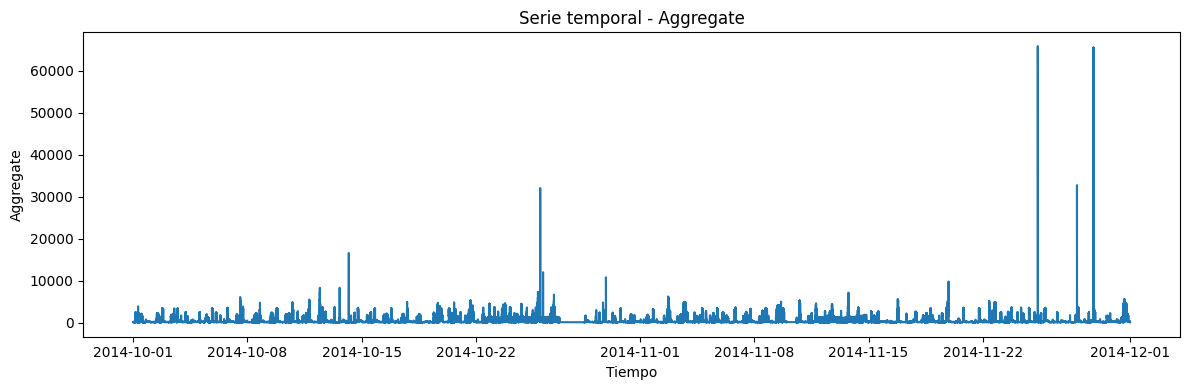

In [ ]:
# Grafica serie de tiempo para el Aggregate
import matplotlib.pyplot as plt

serie = df.set_index('Time')['Aggregate']  # si Time ya es índice, usa: serie = df['Aggregate']
plt.figure(figsize=(12,4))
plt.plot(serie.index, serie.values)
plt.title('Serie temporal - Aggregate')
plt.xlabel('Tiempo'); plt.ylabel('Aggregate')
plt.tight_layout(); plt.show()

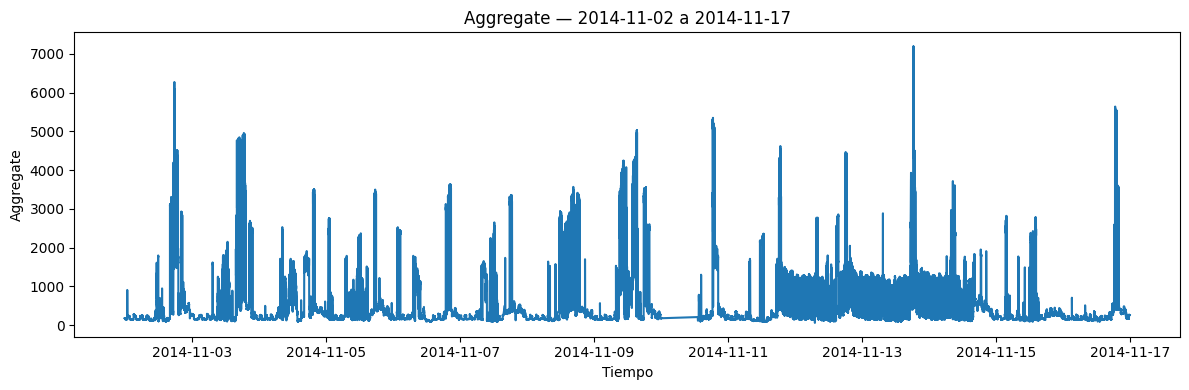

In [ ]:
#Graficar varios días desde la fecha que indiques
import pandas as pd
import matplotlib.pyplot as plt

if df.index.name != 'Time':
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df.set_index('Time').sort_index()

inicio = pd.Timestamp('2014-11-02')   # <-- cambia la fecha inicial
fin = inicio + pd.Timedelta(days=15)
win = df.loc[inicio:fin]

serie = pd.to_numeric(win['Aggregate'], errors='coerce')

plt.figure(figsize=(12,4))
plt.plot(serie.index, serie.values)
plt.title(f'Aggregate — {inicio:%Y-%m-%d} a {fin:%Y-%m-%d}')
plt.xlabel('Tiempo'); plt.ylabel('Aggregate')
plt.tight_layout(); plt.show()